In [1]:
import pandas as pd
import json
df1 = pd.read_csv('dataset_train.csv')
df1.head()

,timestamp,TP2,TP3,H1,DV_pressure,Reservoirs,Oil_temperature,Flowmeter,Motor_current,COMP,...,Towers,MPG,LPS,Pressure_switch,Oil_level,Caudal_impulses,gpsLong,gpsLat,gpsSpeed,gpsQuality
0,2022-01-01 06:00:00,-0.012,9.758,9.760,-0.028,1.576,63.350,19.049625,3.9550,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
1,2022-01-01 06:00:01,-0.012,9.760,9.760,-0.028,1.578,63.250,19.049625,4.0275,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
2,2022-01-01 06:00:02,-0.010,9.760,9.760,-0.028,1.578,63.325,19.040281,3.9450,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
3,2022-01-01 06:00:03,-0.012,9.756,9.756,-0.030,1.576,63.200,19.040281,3.9300,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1
4,2022-01-01 06:00:04,-0.012,9.756,9.756,-0.030,1.578,63.150,19.049625,3.9950,1,...,1,1,0,0,0,0,-8.65934,41.2124,0,1


In [2]:
print(df1.shape)

(10773588, 21)


In [3]:
print(df1['timestamp'].min(),df1['timestamp'].max())
df1['timestamp'] = pd.to_datetime(df1['timestamp'])

2022-01-01 06:00:00 2022-06-02 15:49:53


In [4]:
time1_start,time1_end = pd.to_datetime('2022-02-28 21:53'),pd.to_datetime('2022-03-01 02:00')
time2_start,time2_end = pd.to_datetime('2022-03-23 14:54'), pd.to_datetime('2022-03-23 15:24')
time3_start,time3_end = pd.to_datetime('2022-05-30 12:00'),pd.to_datetime('2022-06-02 06:18')

In [5]:
def labeling(x):
    if x>=time1_start and x<time1_end:
        return 1
    elif x>=time2_start and x<time2_end:
        return 1
    elif x>=time3_start and x<time3_end:
        return 1
    else:
        return 0

In [6]:
### data after 2022-April will be used in real time prediction
df1 = df1[df1['timestamp']<pd.to_datetime('2022-05-01')]

In [7]:
df1['label'] = df1['timestamp'].map(labeling)

In [8]:
df1['label'].value_counts()

0    8410341
1      16620
Name: label, dtype: int64

In [9]:
binary_columns = df1.columns[(df1.eq(0) | df1.eq(1)).all()]
binary_columns

Index(['COMP', 'DV_eletric', 'Towers', 'MPG', 'LPS', 'Pressure_switch',
       'Oil_level', 'Caudal_impulses', 'gpsQuality', 'label'],
      dtype='object')

In [10]:
non_binary_columns = df1.columns[~(df1.eq(0) | df1.eq(1)).all()]
non_binary_columns = non_binary_columns[1:]
non_binary_columns

Index(['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Flowmeter', 'Motor_current', 'gpsLong', 'gpsLat', 'gpsSpeed'],
      dtype='object')

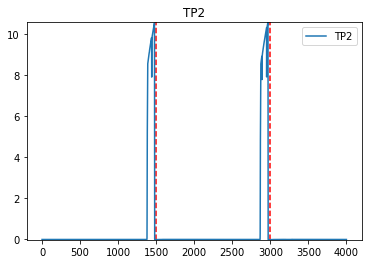

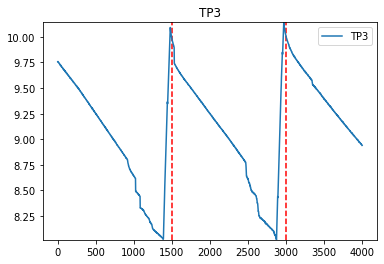

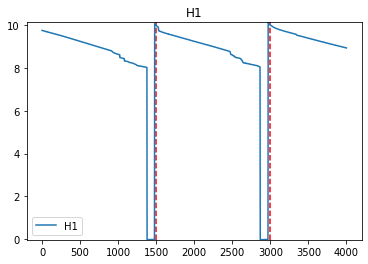

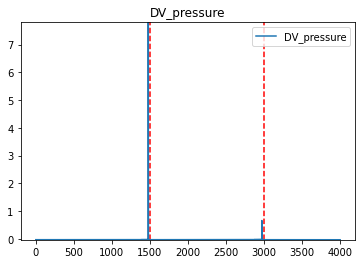

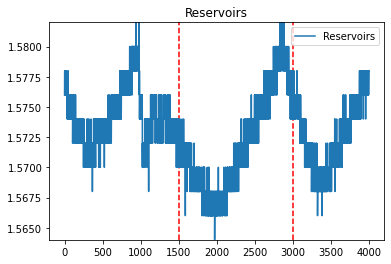

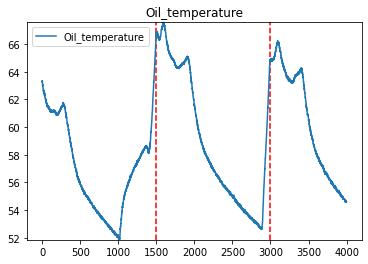

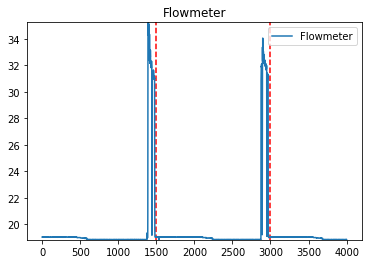

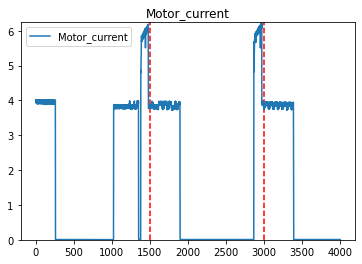

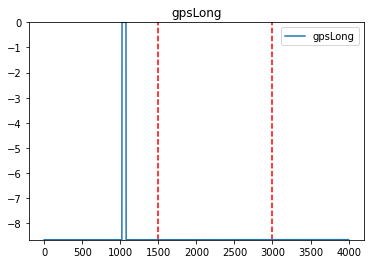

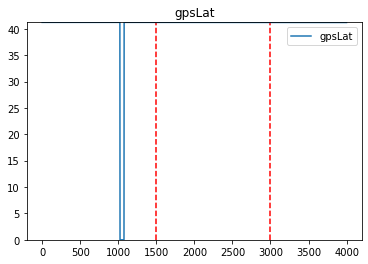

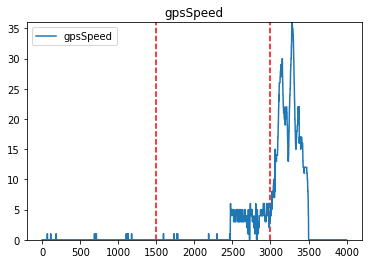

In [11]:
import matplotlib.pyplot as plt
for col in non_binary_columns:
    plt.figure()
    target  = df1[col][:4000]
    target.plot(label=col)
    ymin = min(target)
    ymax = max(target)
    plt.ylim(ymin,ymax)
    plt.vlines(x=1500, ymin=ymin, ymax=ymax, colors='r', linestyles='dashed')
    plt.vlines(x=3000, ymin=ymin, ymax=ymax, colors='r', linestyles='dashed')
    plt.legend()
    plt.title(col)

In [12]:
### create rolling window and lag feaures
for col in ['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs', 'Oil_temperature',
       'Flowmeter', 'Motor_current']:
    df1['rolling_mean_'+col] = df1[col].rolling(1500).mean()
    df1['rolling_min_'+col] = df1[col].rolling(1500).min()
    df1['rolling_max_'+col] = df1[col].rolling(1500).max()
    df1[col+'_lag']  = df1[col].shift(1500)

In [13]:
df1 =df1[[ 'rolling_mean_TP2', 'rolling_min_TP2', 'rolling_max_TP2',
       'rolling_mean_TP3', 'rolling_min_TP3', 'rolling_max_TP3',
       'rolling_mean_H1', 'rolling_min_H1', 'rolling_max_H1',
       'rolling_mean_DV_pressure', 'rolling_min_DV_pressure',
       'rolling_max_DV_pressure', 'rolling_mean_Reservoirs',
       'rolling_min_Reservoirs', 'rolling_max_Reservoirs',
       'rolling_mean_Oil_temperature', 'rolling_min_Oil_temperature',
       'rolling_max_Oil_temperature', 'rolling_mean_Flowmeter',
       'rolling_min_Flowmeter', 'rolling_max_Flowmeter',
       'rolling_mean_Motor_current', 'rolling_min_Motor_current',
       'rolling_max_Motor_current', 'TP2_lag', 'TP3_lag', 'H1_lag',
       'DV_pressure_lag', 'Reservoirs_lag', 'Oil_temperature_lag',
       'Flowmeter_lag', 'Motor_current_lag']+['TP2', 'TP3', 'H1', 'DV_pressure', 'Reservoirs',
       'Oil_temperature', 'Flowmeter', 'Motor_current', 'COMP', 'DV_eletric',
       'Towers', 'MPG', 'LPS', 'Pressure_switch', 'Oil_level',
       'Caudal_impulses', 'gpsLong', 'gpsLat', 'gpsSpeed', 'gpsQuality']+['timestamp','label']]

In [14]:
df1 = df1.dropna()

In [15]:
train = df1[df1['timestamp']<pd.to_datetime('2022-03-01')].drop('timestamp',axis=1)
test = df1[df1['timestamp']>=pd.to_datetime('2022-03-01')].drop('timestamp',axis=1)

In [16]:
from imblearn.under_sampling import RandomUnderSampler

In [17]:
cc = RandomUnderSampler()
X_res, y_res = cc.fit_resample(train.drop('label',axis=1), train['label'])

In [18]:
 from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_res, y_res, test_size=0.1, random_state=42,stratify = y_res)

In [19]:
import hyperopt
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe
from functools import partial
from xgboost import XGBClassifier
import numpy as np
import warnings 
from sklearn.metrics import roc_auc_score,f1_score,recall_score
warnings.filterwarnings('ignore')

In [20]:
space = {
    'max_depth': hp.choice('max_depth', [2, 4, 6, 8, 10, 12, 14]),
    'subsample': hp.uniform('subsample', 0.25, 1),
    'learning_rate': hp.loguniform('learning_rate', -4, 0),
    'colsample_bytree': hp.uniform('colsample_bytree', 0.7, 1.0),
    'reg_alpha': hp.loguniform('reg_alpha', -5, -1),
    'reg_lambda': hp.loguniform('reg_lambda', -6, -1),
    'min_child_weight': hp.loguniform('min_child_weight', -1, 3),
    'n_estimators': hp.choice('n_estimators', [50, 100, 150]),
    'seed': 42
}

def objective(params, X_train, y_train, X_test, y_test):
    clf=XGBClassifier(**params,  n_jobs = -1)
    
    evaluation = [(X_test, y_test)]

    clf.fit(X_train, y_train,
            eval_set=evaluation, eval_metric="auc",
            early_stopping_rounds=40,verbose=False)
    
    pred = clf.predict(X_test)
    f1 = f1_score(y_test, pred)
    return {'loss': 1-f1 , 'status': hyperopt.STATUS_OK, 'params': params}

def tune_xgb(param_space, X_train, y_train, X_early_stop, y_early_stop, n_iter):  
    
    obj = partial(objective, X_train = X_train, y_train = y_train,
                  X_test = X_early_stop, y_test = y_early_stop)
    
    trials = hyperopt.Trials()
    hyperopt.fmin(fn = obj, space = param_space, algo = hyperopt.tpe.suggest,
                         max_evals = n_iter, trials = trials)
    return trials.best_trial['result']['params']

In [21]:
best_params = tune_xgb(space, X_train , y_train ,  X_test, y_test, n_iter = 50)

100%|███████████████████████████████████████████████████████████████| 50/50 [00:32<00:00,  1.56trial/s, best loss: 0.0]


In [22]:
xg= XGBClassifier(**best_params)
xg.fit(X_res , y_res)

[12:36:36] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8723751386672677, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.09724240322230034, max_delta_step=0, max_depth=8,
              min_child_weight=3.3023142323040675, missing=nan,
              monotone_constraints='()', n_estimators=100, n_jobs=8,
              num_parallel_tree=1, random_state=42,
              reg_alpha=0.007022568888218534, reg_lambda=0.019278190139127068,
              scale_pos_weight=1, seed=42, subsample=0.6174812897965529,
              tree_method='exact', validate_parameters=1, verbosity=None)

In [23]:
#F1,Recall

In [24]:
y_pred = xg.predict(test.drop('label',axis=1))

In [25]:
print(round(roc_auc_score(test['label'], y_pred),3))
print(round(recall_score(test['label'], y_pred),3))
print(round(f1_score(test['label'], y_pred),3))

0.899
0.8
0.704


In [26]:
import joblib
joblib.dump(xg, 'latest_model.pkl')

['latest_model.pkl']